# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'polynomial_data_size': 100,  #number of generated polynomials (for loading)
        'lambda_nets_total': 100, #number of lambda-nets to train
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions 
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000, #lambda-net training dataset size
    },    
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': False,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
    
        'random_evaluation_dataset_size': 500,
    },    
    'computation':{
        'n_jobs': 5,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'
    
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)

config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']
    
transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

initialize_utility_functions_config_from_curent_notebook(config)
initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


In [7]:
print(path_identifier_lambda_net_data)

print(path_identifier_polynomial_data)


lnets_100_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0
poly_100_train_5000_var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0_diffX


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [9]:
lambda_network_layers

[75]

In [10]:
path_polynomials = './data/saved_polynomial_lists/polynomials_sample_' + path_identifier_polynomial_data + '.csv'
polynomials_list_df = pd.read_csv(path_polynomials)

path_X_data = './data/saved_polynomial_lists/X_sample_' + path_identifier_polynomial_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_polynomial_lists/y_sample_' + path_identifier_polynomial_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if lambda_nets_total < polynomial_data_size:
    polynomials_list_df = polynomials_list_df.sample(n=lambda_nets_total, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)

## Data Inspection

In [11]:
X_data_list[0][1].head(10)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
0,0.417,0.720,0.000,0.302,0.147,0.092,0.186,0.346,0.397,0.539,0.419,0.685,0.204,0.878,0.027
1,0.670,0.417,0.559,0.140,0.198,0.801,0.968,0.313,0.692,0.876,0.895,0.085,0.039,0.170,0.878
2,0.098,0.421,0.958,0.533,0.692,0.316,0.687,0.835,0.018,0.750,0.989,0.748,0.280,0.789,0.103
3,0.448,0.909,0.294,0.288,0.130,0.019,0.679,0.212,0.266,0.492,0.053,0.574,0.147,0.589,0.700
4,0.102,0.414,0.694,0.414,0.050,0.536,0.664,0.515,0.945,0.587,0.903,0.137,0.139,0.807,0.398
5,0.165,0.928,0.348,0.751,0.726,0.883,0.624,0.751,0.349,0.270,0.896,0.428,0.965,0.663,0.622
6,0.115,0.949,0.450,0.578,0.408,0.237,0.903,0.574,0.003,0.617,0.327,0.527,0.886,0.357,0.909
7,0.623,0.016,0.929,0.691,0.997,0.172,0.137,0.933,0.697,0.066,0.755,0.754,0.923,0.712,0.124
8,0.020,0.026,0.028,0.246,0.860,0.539,0.553,0.842,0.124,0.279,0.586,0.970,0.561,0.019,0.801
9,0.233,0.807,0.388,0.864,0.747,0.556,0.136,0.060,0.121,0.045,0.107,0.226,0.713,0.560,0.013


In [12]:
y_data_list[0][1].head(10)

,result
0,-0.035
1,-0.605
2,-1.288
3,-0.093
4,-0.544
5,-0.612
6,-0.443
7,-0.624
8,-0.363
9,-0.609


In [13]:
X_data_list[0][0].head(10)

300000000000000   0.000
210000000000000   0.000
201000000000000   0.000
200100000000000   0.000
200010000000000   0.000
200001000000000   0.000
200000100000000   0.000
200000010000000   0.000
200000001000000   0.000
200000000100000   0.000
dtype: float64

In [14]:
y_data_list[0][0].head(10)

300000000000000   0.000
210000000000000   0.000
201000000000000   0.000
200100000000000   0.000
200010000000000   0.000
200001000000000   0.000
200000100000000   0.000
200000010000000   0.000
200000001000000   0.000
200000000100000   0.000
dtype: float64

## Lambda Network Training + Weigh/Bias saving

In [15]:
#%autoreload 2
clf_list = []
chunksize = 5000 if lambda_nets_total > 50000 else max(lambda_nets_total//10, min(50, lambda_nets_total))
X_data_list_splits = list(chunks(X_data_list, chunksize))
y_data_list_splits = list(chunks(y_data_list, chunksize))

max_seed = 2147483646
seed_list = random.sample(range(0, max_seed), number_different_lambda_trainings)
chunk_multiplier = 0

for X_data_list_split, y_data_list_split in tqdm(zip(X_data_list_splits, y_data_list_splits), total=max(len(X_data_list_splits), len(y_data_list_splits))):
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    clf_sublist = parallel(delayed(train_nn)(chunksize*chunk_multiplier+index, X_data[1].values, y_data[1].values, X_data[0], seed_list, return_history=True, each_epochs_save=each_epochs_save_lambda, printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list_split, y_data_list_split)))  
    clf_list.extend(clf_sublist)
    del parallel
    chunk_multiplier +=1

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 12.8min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 26.3min finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 24.8min finished


In [16]:
#%load_ext autoreload

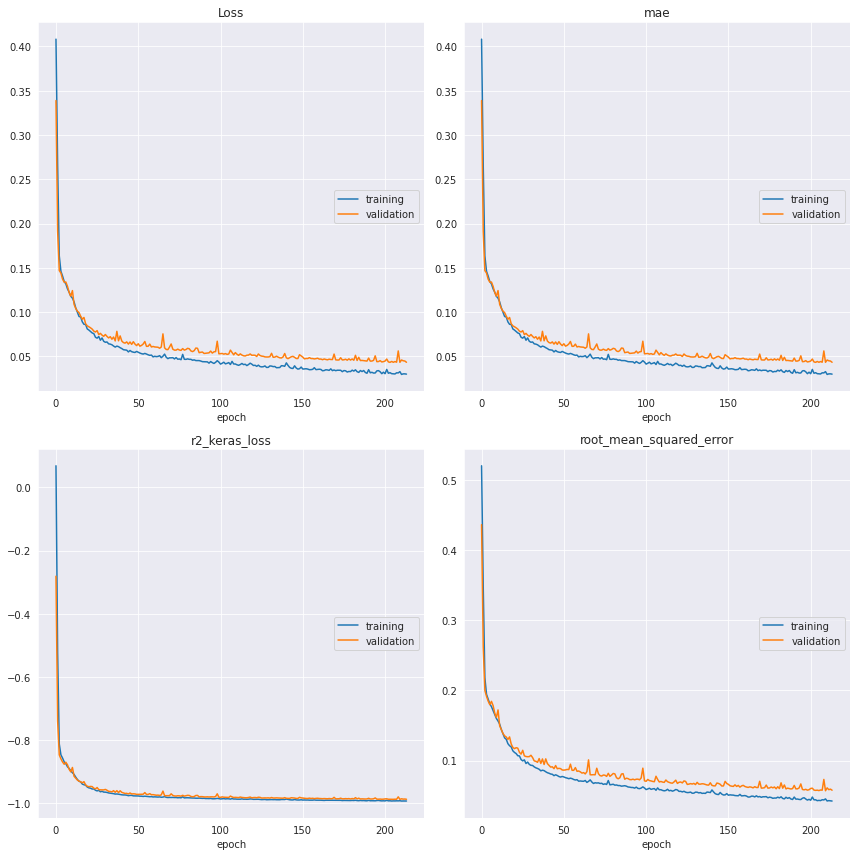

Loss
	training         	 (min:    0.030, max:    0.408, cur:    0.030)
	validation       	 (min:    0.043, max:    0.339, cur:    0.043)
mae
	training         	 (min:    0.030, max:    0.408, cur:    0.030)
	validation       	 (min:    0.043, max:    0.339, cur:    0.043)
r2_keras_loss
	training         	 (min:   -0.993, max:    0.068, cur:   -0.993)
	validation       	 (min:   -0.988, max:   -0.281, cur:   -0.987)
root_mean_squared_error
	training         	 (min:    0.042, max:    0.521, cur:    0.042)
	validation       	 (min:    0.057, max:    0.437, cur:    0.058)


In [17]:
#%autoreload 2
rand_index = np.random.randint(lambda_nets_total)

random_network = train_nn(rand_index, X_data_list[rand_index][1], y_data_list[rand_index][1], X_data_list[rand_index][0], seed_list, callbacks=[PlotLossesKerasTF()], return_model=True)

## Save and Plot Lambda-Model History

In [18]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry[3]
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry[3]
    index = entry[0][0]
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=list(flatten(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=list(flatten(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))) 
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=list(flatten(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=list(flatten(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [20]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,loss_epoch_100,loss_epoch_101,loss_epoch_102,loss_epoch_103,loss_epoch_104,loss_epoch_105,loss_epoch_106,loss_epoch_107,loss_epoch_108,loss_epoch_109,loss_epoch_110,loss_epoch_111,loss_epoch_112,loss_epoch_113,loss_epoch_114,loss_epoch_115,loss_epoch_116,loss_epoch_117,loss_epoch_118,loss_epoch_119,loss_epoch_120,loss_epoch_121,loss_epoch_122,loss_epoch_123,loss_epoch_124,loss_epoch_125,loss_epoch_126,loss_epoch_127,loss_epoch_128,loss_epoch_129,loss_epoch_130,loss_epoch_131,loss_epoch_132,loss_epoch_133,loss_epoch_134,loss_epoch_135,loss_epoch_136,loss_epoch_137,loss_epoch_138,loss_epoch_139,loss_epoch_140,loss_epoch_141,loss_epoch_142,loss_epoch_143,loss_epoch_144,loss_epoch_145,loss_epoch_146,loss_epoch_147,loss_epoch_148,loss_epoch_149,loss_epoch_150,loss_epoch_151,loss_epoch_152,loss_epoch_153,loss_epoch_154,loss_epoch_155,loss_epoch_156,loss_epoch_157,loss_epoch_158,loss_epoch_159,loss_epoch_160,loss_epoch_161,loss_epoch_162,loss_epoch_163,loss_epoch_164,loss_epoch_165,loss_epoch_166,loss_epoch_167,loss_epoch_168,loss_epoch_169,loss_epoch_170,loss_epoch_171,loss_epoch_172,loss_epoch_173,loss_epoch_174,loss_epoch_175,loss_epoch_176,loss_epoch_177,loss_epoch_178,loss_epoch_179,loss_epoch_180,loss_epoch_181,loss_epoch_182,loss_epoch_183,loss_epoch_184,loss_epoch_185,loss_epoch_186,loss_epoch_187,loss_epoch_188,loss_epoch_189,loss_epoch_190,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200,loss_epoch_201,loss_epoch_202,loss_epoch_203,loss_epoch_204,loss_epoch_205,loss_epoch_206,loss_epoch_207,loss_epoch_208,loss_epoch_209,loss_epoch_210,loss_epoch_211,loss_epoch_212,loss_epoch_213,loss_epoch_214,loss_epoch_215,loss_epoch_216,loss_epoch_217,loss_epoch_218,loss_epoch_219,loss_epoch_220,loss_epoch_221,loss_epoch_222,loss_epoch_223,loss_epoch_224,loss_epoch_225,loss_epoch_226,loss_epoch_227
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,99.000,98.000,98.000,98.000,98.000,98.000,98.000,97.000,97.000,96.000,96.000,95.000,95.000,95.000,95.000,95.000,93.000,93.000,93.000,93.000,

In [21]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,val_loss_epoch_100,val_loss_epoch_101,val_loss_epoch_102,val_loss_epoch_103,val_loss_epoch_104,val_loss_epoch_105,val_loss_epoch_106,val_loss_epoch_107,val_loss_epoch_108,val_loss_epoch_109,val_loss_epoch_110,val_loss_epoch_111,val_loss_epoch_112,val_loss_epoch_113,val_loss_epoch_114,val_loss_epoch_115,val_loss_epoch_116,val_loss_epoch_117,val_loss_epoch_118,val_loss_epoch_119,val_loss_epoch_120,val_loss_epoch_121,val_loss_epoch_122,val_loss_epoch_123,val_loss_epoch_124,val_loss_epoch_125,val_loss_epoch_126,val_loss_epoch_127,val_loss_epoch_128,val_loss_epoch_129,val_loss_epoch_130,val_loss_epoch_131,val_loss_epoch_132,val_loss_epoch_133,val_loss_epoch_134,val_loss_epoch_135,val_loss_epoch_136,val_loss_epoch_137,val_loss_epoch_138,val_loss_epoch_139,val_loss_epoch_140,val_loss_epoch_141,val_loss_epoch_142,val_loss_epoch_143,val_loss_epoch_144,val_loss_epoch_145,val_loss_epoch_146,val_loss_epoch_147,val_loss_epoch_148,val_loss_epoch_149,val_loss_epoch_150,val_loss_epoch_151,val_loss_epoch_152,val_loss_epoch_153,val_loss_epoch_154,val_loss_epoch_155,val_loss_epoch_156,val_loss_epoch_157,val_loss_epoch_158,val_loss_epoch_159,val_loss_epoch_160,val_loss_epoch_161,val_loss_epoch_162,val_loss_epoch_163,val_loss_epoch_164,val_loss_epoch_165,val_loss_epoch_166,val_loss_epoch_167,val_loss_epoch_168,val_loss_epoch_169,val_loss_epoch_170,val_loss_epoch_171,val_loss_epoch_172,val_loss_epoch_173,val_loss_epoch_174,val_loss_epoch_175,val_loss_epoch_176,val_loss_epoch_177,val_loss_epoch_178,val_loss_epoch_179,val_loss_epoch_180,val_loss_epoch_181,val_loss_epoch_182,val_loss_epoch_183,val_loss_epoch_184,val_loss_epoch_185,val_loss_epoch_186,val_loss_epoch_187,val_loss_epoch_188,val_loss_epoch_189,val_loss_epoch_190,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200,val_loss_epoch_201,val_loss_epoch_202,val_loss_epoch_203,val_loss_epoch_204,val_loss_epoch_205,val_loss_epoch_206,val_loss_epoch_207,val_loss_epoch_208,val_loss_epoch_209,val_loss_epoch_210,val_loss_epoch_211,val_loss_epoch_212,val_loss_epoch_213,val_loss_epoch_214,val_loss_epoch_215,val_loss_epoch_2

In [22]:
metric_df.describe()

,index,r2_keras_loss_epoch_1,r2_keras_loss_epoch_2,r2_keras_loss_epoch_3,r2_keras_loss_epoch_4,r2_keras_loss_epoch_5,r2_keras_loss_epoch_6,r2_keras_loss_epoch_7,r2_keras_loss_epoch_8,r2_keras_loss_epoch_9,r2_keras_loss_epoch_10,r2_keras_loss_epoch_11,r2_keras_loss_epoch_12,r2_keras_loss_epoch_13,r2_keras_loss_epoch_14,r2_keras_loss_epoch_15,r2_keras_loss_epoch_16,r2_keras_loss_epoch_17,r2_keras_loss_epoch_18,r2_keras_loss_epoch_19,r2_keras_loss_epoch_20,r2_keras_loss_epoch_21,r2_keras_loss_epoch_22,r2_keras_loss_epoch_23,r2_keras_loss_epoch_24,r2_keras_loss_epoch_25,r2_keras_loss_epoch_26,r2_keras_loss_epoch_27,r2_keras_loss_epoch_28,r2_keras_loss_epoch_29,r2_keras_loss_epoch_30,r2_keras_loss_epoch_31,r2_keras_loss_epoch_32,r2_keras_loss_epoch_33,r2_keras_loss_epoch_34,r2_keras_loss_epoch_35,r2_keras_loss_epoch_36,r2_keras_loss_epoch_37,r2_keras_loss_epoch_38,r2_keras_loss_epoch_39,r2_keras_loss_epoch_40,r2_keras_loss_epoch_41,r2_keras_loss_epoch_42,r2_keras_loss_epoch_43,r2_keras_loss_epoch_44,r2_keras_loss_epoch_45,r2_keras_loss_epoch_46,r2_keras_loss_epoch_47,r2_keras_loss_epoch_48,r2_keras_loss_epoch_49,r2_keras_loss_epoch_50,r2_keras_loss_epoch_51,r2_keras_loss_epoch_52,r2_keras_loss_epoch_53,r2_keras_loss_epoch_54,r2_keras_loss_epoch_55,r2_keras_loss_epoch_56,r2_keras_loss_epoch_57,r2_keras_loss_epoch_58,r2_keras_loss_epoch_59,r2_keras_loss_epoch_60,r2_keras_loss_epoch_61,r2_keras_loss_epoch_62,r2_keras_loss_epoch_63,r2_keras_loss_epoch_64,r2_keras_loss_epoch_65,r2_keras_loss_epoch_66,r2_keras_loss_epoch_67,r2_keras_loss_epoch_68,r2_keras_loss_epoch_69,r2_keras_loss_epoch_70,r2_keras_loss_epoch_71,r2_keras_loss_epoch_72,r2_keras_loss_epoch_73,r2_keras_loss_epoch_74,r2_keras_loss_epoch_75,r2_keras_loss_epoch_76,r2_keras_loss_epoch_77,r2_keras_loss_epoch_78,r2_keras_loss_epoch_79,r2_keras_loss_epoch_80,r2_keras_loss_epoch_81,r2_keras_loss_epoch_82,r2_keras_loss_epoch_83,r2_keras_loss_epoch_84,r2_keras_loss_epoch_85,r2_keras_loss_epoch_86,r2_keras_loss_epoch_87,r2_keras_loss_epoch_88,r2_keras_loss_epoch_89,r2_keras_loss_epoch_90,r2_keras_loss_epoch_91,r2_keras_loss_epoch_92,r2_keras_loss_epoch_93,r2_keras_loss_epoch_94,r2_keras_loss_epoch_95,r2_keras_loss_epoch_96,r2_keras_loss_epoch_97,r2_keras_loss_epoch_98,r2_keras_loss_epoch_99,r2_keras_loss_epoch_100,r2_keras_loss_epoch_101,r2_keras_loss_epoch_102,r2_keras_loss_epoch_103,r2_keras_loss_epoch_104,r2_keras_loss_epoch_105,r2_keras_loss_epoch_106,r2_keras_loss_epoch_107,r2_keras_loss_epoch_108,r2_keras_loss_epoch_109,r2_keras_loss_epoch_110,r2_keras_loss_epoch_111,r2_keras_loss_epoch_112,r2_keras_loss_epoch_113,r2_keras_loss_epoch_114,r2_keras_loss_epoch_115,r2_keras_loss_epoch_116,r2_keras_loss_epoch_117,r2_keras_loss_epoch_118,r2_keras_loss_epoch_119,r2_keras_loss_epoch_120,r2_keras_loss_epoch_121,r2_keras_loss_epoch_122,r2_keras_loss_epoch_123,r2_keras_loss_epoch_124,r2_keras_loss_epoch_125,r2_keras_loss_epoch_126,r2_keras_loss_epoch_127,r2_keras_loss_epoch_128,r2_keras_loss_epoch_129,r2_keras_loss_epoch_130,r2_keras_loss_epoch_131,r2_keras_loss_epoch_132,r2_keras_loss_epoch_133,r2_keras_loss_epoch_134,r2_keras_loss_epoch_135,r2_keras_loss_epoch_136,r2_keras_loss_epoch_137,r2_keras_loss_epoch_138,r2_keras_loss_epoch_139,r2_keras_loss_epoch_140,r2_keras_loss_epoch_141,r2_keras_loss_epoch_142,r2_keras_loss_epoch_143,r2_keras_loss_epoch_144,r2_keras_loss_epoch_145,r2_keras_loss_epoch_146,r2_keras_loss_epoch_147,r2_keras_loss_epoch_148,r2_keras_loss_epoch_149,r2_keras_loss_epoch_150,r2_keras_loss_epoch_151,r2_keras_loss_epoch_152,r2_keras_loss_epoch_153,r2_keras_loss_epoch_154,r2_keras_loss_epoch_155,r2_keras_loss_epoch_156,r2_keras_loss_epoch_157,r2_keras_loss_epoch_158,r2_keras_loss_epoch_159,r2_keras_loss_epoch_160,r2_keras_loss_epoch_161,r2_keras_loss_epoch_162,r2_keras_loss_epoch_163,r2_keras_loss_epoch_164,r2_keras_loss_epoch_165,r2_keras_loss_epoch_166,r2_keras_loss_epoch_167,r2_keras_loss_epoch_168,r2_keras_loss_epoch_169,r2_keras_loss_epoch_170,r2_keras_loss_epoch_1

In [23]:
val_metric_df.describe()

,index,val_r2_keras_loss_epoch_1,val_r2_keras_loss_epoch_2,val_r2_keras_loss_epoch_3,val_r2_keras_loss_epoch_4,val_r2_keras_loss_epoch_5,val_r2_keras_loss_epoch_6,val_r2_keras_loss_epoch_7,val_r2_keras_loss_epoch_8,val_r2_keras_loss_epoch_9,val_r2_keras_loss_epoch_10,val_r2_keras_loss_epoch_11,val_r2_keras_loss_epoch_12,val_r2_keras_loss_epoch_13,val_r2_keras_loss_epoch_14,val_r2_keras_loss_epoch_15,val_r2_keras_loss_epoch_16,val_r2_keras_loss_epoch_17,val_r2_keras_loss_epoch_18,val_r2_keras_loss_epoch_19,val_r2_keras_loss_epoch_20,val_r2_keras_loss_epoch_21,val_r2_keras_loss_epoch_22,val_r2_keras_loss_epoch_23,val_r2_keras_loss_epoch_24,val_r2_keras_loss_epoch_25,val_r2_keras_loss_epoch_26,val_r2_keras_loss_epoch_27,val_r2_keras_loss_epoch_28,val_r2_keras_loss_epoch_29,val_r2_keras_loss_epoch_30,val_r2_keras_loss_epoch_31,val_r2_keras_loss_epoch_32,val_r2_keras_loss_epoch_33,val_r2_keras_loss_epoch_34,val_r2_keras_loss_epoch_35,val_r2_keras_loss_epoch_36,val_r2_keras_loss_epoch_37,val_r2_keras_loss_epoch_38,val_r2_keras_loss_epoch_39,val_r2_keras_loss_epoch_40,val_r2_keras_loss_epoch_41,val_r2_keras_loss_epoch_42,val_r2_keras_loss_epoch_43,val_r2_keras_loss_epoch_44,val_r2_keras_loss_epoch_45,val_r2_keras_loss_epoch_46,val_r2_keras_loss_epoch_47,val_r2_keras_loss_epoch_48,val_r2_keras_loss_epoch_49,val_r2_keras_loss_epoch_50,val_r2_keras_loss_epoch_51,val_r2_keras_loss_epoch_52,val_r2_keras_loss_epoch_53,val_r2_keras_loss_epoch_54,val_r2_keras_loss_epoch_55,val_r2_keras_loss_epoch_56,val_r2_keras_loss_epoch_57,val_r2_keras_loss_epoch_58,val_r2_keras_loss_epoch_59,val_r2_keras_loss_epoch_60,val_r2_keras_loss_epoch_61,val_r2_keras_loss_epoch_62,val_r2_keras_loss_epoch_63,val_r2_keras_loss_epoch_64,val_r2_keras_loss_epoch_65,val_r2_keras_loss_epoch_66,val_r2_keras_loss_epoch_67,val_r2_keras_loss_epoch_68,val_r2_keras_loss_epoch_69,val_r2_keras_loss_epoch_70,val_r2_keras_loss_epoch_71,val_r2_keras_loss_epoch_72,val_r2_keras_loss_epoch_73,val_r2_keras_loss_epoch_74,val_r2_keras_loss_epoch_75,val_r2_keras_loss_epoch_76,val_r2_keras_loss_epoch_77,val_r2_keras_loss_epoch_78,val_r2_keras_loss_epoch_79,val_r2_keras_loss_epoch_80,val_r2_keras_loss_epoch_81,val_r2_keras_loss_epoch_82,val_r2_keras_loss_epoch_83,val_r2_keras_loss_epoch_84,val_r2_keras_loss_epoch_85,val_r2_keras_loss_epoch_86,val_r2_keras_loss_epoch_87,val_r2_keras_loss_epoch_88,val_r2_keras_loss_epoch_89,val_r2_keras_loss_epoch_90,val_r2_keras_loss_epoch_91,val_r2_keras_loss_epoch_92,val_r2_keras_loss_epoch_93,val_r2_keras_loss_epoch_94,val_r2_keras_loss_epoch_95,val_r2_keras_loss_epoch_96,val_r2_keras_loss_epoch_97,val_r2_keras_loss_epoch_98,val_r2_keras_loss_epoch_99,val_r2_keras_loss_epoch_100,val_r2_keras_loss_epoch_101,val_r2_keras_loss_epoch_102,val_r2_keras_loss_epoch_103,val_r2_keras_loss_epoch_104,val_r2_keras_loss_epoch_105,val_r2_keras_loss_epoch_106,val_r2_keras_loss_epoch_107,val_r2_keras_loss_epoch_108,val_r2_keras_loss_epoch_109,val_r2_keras_loss_epoch_110,val_r2_keras_loss_epoch_111,val_r2_keras_loss_epoch_112,val_r2_keras_loss_epoch_113,val_r2_keras_loss_epoch_114,val_r2_keras_loss_epoch_115,val_r2_keras_loss_epoch_116,val_r2_keras_loss_epoch_117,val_r2_keras_loss_epoch_118,val_r2_keras_loss_epoch_119,val_r2_keras_loss_epoch_120,val_r2_keras_loss_epoch_121,val_r2_keras_loss_epoch_122,val_r2_keras_loss_epoch_123,val_r2_keras_loss_epoch_124,val_r2_keras_loss_epoch_125,val_r2_keras_loss_epoch_126,val_r2_keras_loss_epoch_127,val_r2_keras_loss_epoch_128,val_r2_keras_loss_epoch_129,val_r2_keras_loss_epoch_130,val_r2_keras_loss_epoch_131,val_r2_keras_loss_epoch_132,val_r2_keras_loss_epoch_133,val_r2_keras_loss_epoch_134,val_r2_keras_loss_epoch_135,val_r2_keras_loss_epoch_136,val_r2_keras_loss_epoch_137,val_r2_keras_loss_epoch_138,val_r2_keras_loss_epoch_139,val_r2_keras_loss_epoch_140,val_r2_keras_loss_epoch_141,val_r2_keras_loss_epoch_142,val_r2_keras_loss_epoch_143,val_r2_keras_loss_epoch_144,val_r2_keras_loss_epoch_145,val_r2_keras_loss_epoch_146,val_r2_keras_

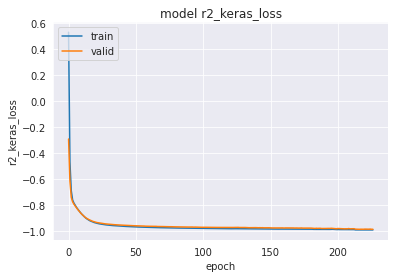

In [24]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


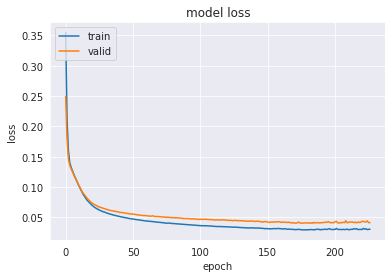

In [25]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '_epoch_' + str(epochs_lambda).zfill(3) + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
